#### Business Analytics FHDW 2025
# Time Series
## Regressionsbasierte Vorhersagen

Wir nutzen wieder *Amtrak.csv* mit seinen Fahrgastzahlen. Die *ridership*-Zeitreihe leiten wir uns wie im Beispiel davor daraus ab und transformieren auch wieder die Monatsdaten in einen Zeitindex. Die etwas aufwändigere, wiederkehrende grafische Darstellung packen wir zu Teilen in Funktionen `graphLayout` und `singleGraphLayout`.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pylab as plt
import statsmodels.formula.api as smf
from statsmodels.tsa import tsatools
from sklearn.metrics import mean_squared_error
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.graphics import tsaplots

def regressionSummary(y_true, y_predicted):
    y_true = np.asarray(y_true)
    y_predicted = np.asarray(y_predicted)
    y_residuals = y_true - y_predicted
    metrics = [
        ('Summe Abweichungen', sum(y_residuals)),
        ('Summe absolute Abweichungen', sum(abs(y_residuals))),
        ('Mittlerer Fehler', sum(y_residuals) / len(y_residuals)),
        ('Mittlerer absoluter Fehler', sum(abs(y_residuals)) / len(y_residuals)),
        ('Wurzel des durchschnittlichen Fehlerquadrats', np.sqrt(mean_squared_error(y_true, y_predicted)))
    ]
    if all(yt != 0 for yt in y_true):
        metrics.extend([
            ('Mittlerer prozentualer Fehler', 100 * sum(y_residuals / y_true) / len(y_residuals)),
            ('Mittlerer absoluter prozentualer Fehler', 100 * sum(abs(y_residuals / y_true) / len(y_residuals))),
        ])
    maxlength = max(len(m[0]) for m in metrics)
    fmt1 = f'{{:>{maxlength}}} : {{:.4f}}'    
    for metric, value in metrics:
        print(fmt1.format(metric, value))

def singleGraphLayout(ax, ylim, train_df, valid_df):
    ax.set_xlim('1990', '2004-6')
    ax.set_ylim(*ylim)
    ax.set_xlabel('Zeit')
    one_month = pd.Timedelta('31 days')
    
    xtrain = (min(train_df.index), max(train_df.index)-one_month)
    xvalid = (min(valid_df.index)+one_month, max(valid_df.index)-one_month)
    xtv = xtrain[1]+0.5*(xvalid[0]-xtrain[1])
    
    ypos = 0.9*ylim[1]+0.1*ylim[0]
    ax.add_line(plt.Line2D(xtrain, (ypos, ypos), color='black', linewidth=0.5))
    ax.add_line(plt.Line2D(xvalid, (ypos, ypos), color='black', linewidth=0.5))
    ax.axvline(x=xtv, ymin=0, ymax=1, color='black', linewidth=0.5)
    
    ypos = 0.925*ylim[1]+0.075*ylim[0]
    ax.text('1995', ypos, 'Training')
    ax.text('2002-3', ypos, 'Validation')
    
def graphLayout(axes, train_df, valid_df):
    singleGraphLayout(axes[0], [1300, 2550], train_df, valid_df)
    singleGraphLayout(axes[1], [-550, 550], train_df, valid_df)
    train_df.plot(y='Ridership', ax=axes[0], color='C0', linewidth=0.75)
    valid_df.plot(y='Ridership', ax=axes[0], color='C0', linestyle='dashed', linewidth=0.75)
    axes[1].axhline(y=0, xmin=0, xmax=1, color='black', linewidth=0.5)
    axes[0].set_xlabel('')
    axes[0].set_ylabel('Fahrgäste in tausend')
    axes[1].set_ylabel('Vorhersagefehler')
    if axes[0].get_legend():
        axes[0].get_legend().remove()

amtrak_df = pd.read_csv('Daten/Amtrak.csv')
amtrak_df['Date'] = pd.to_datetime(amtrak_df.Month, format='%d/%m/%Y')
ridership_ts = pd.Series(amtrak_df.Ridership.values, index=amtrak_df.Date, name='Ridership')
ridership_ts

Date
1991-01-01    1708.917
1991-02-01    1620.586
1991-03-01    1972.715
1991-04-01    1811.665
1991-05-01    1974.964
                ...   
2003-11-01    2076.054
2003-12-01    2140.677
2004-01-01    1831.508
2004-02-01    1838.006
2004-03-01    2132.446
Name: Ridership, Length: 159, dtype: float64

Auf die Zeitreihe passen wir ein einfaches lineares Trendmodell an. Dazu nutzen wir in diesem Fall *tsatools*, was uns Werkzeuge spezifisch zur Arbeit mit Zeitreihen bietet. `add_trend` erzeugt aus der Fahrgästezeitreihe ein DataFrame und erweitert es mit dem Parameter `trend='t'` um eine lineare Prädiktorvariable mit einem Wert für jeden Zeitschritt (auch die zeitbezogene Regression arbeitet mit den bekannten Formeln; mit der Kodierung `datetime64` von *Date* können diese nicht viel anfangen, daher die Vereinfachung/Übersetzung). 

In [2]:
ridership_df = tsatools.add_trend(ridership_ts, trend='t')
ridership_df

,Ridership,trend
Date,,
1991-01-01,1708.917,1.0
1991-02-01,1620.586,2.0
1991-03-01,1972.715,3.0
1991-04-01,1811.665,4.0
1991-05-01,1974.964,5.0
...,...,...
2003-11-01,2076.054,155.0
2003-12-01,2140.677,156.0
2004-01-01,1831.508,157.0


Diesen Datensatz können wir nun als Eingabe für eine *ordinary least squares*-Regression `ols` nutzen. *statsmodels* erlaubt uns, dazu explizit eine Formel mit der Vorhersage `Ridership` in Abhängigkeit vom Prädiktor `trend` zu definieren. `Ridership ~ trend` entspricht dabei $Y_t = \beta_0 + \beta_1 t + \epsilon$. Mit `fit` nimmt das resultierende Modell dann die Anpassung vor. Das Ergebnis stellen wir dar.

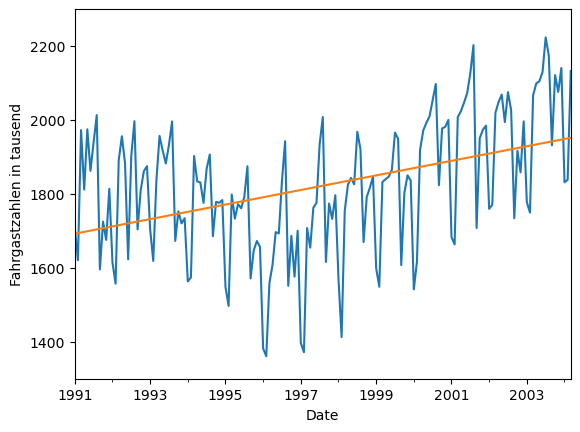

In [3]:
ridership_lin_reg = smf.ols(formula='Ridership ~ trend', data=ridership_df).fit()
ax = ridership_ts.plot()
ax.set_xlabel('Zeit')
ax.set_ylabel('Fahrgastzahlen in tausend')
ax.set_ylim(1300, 2300)
ridership_lin_reg.predict(ridership_df).plot(ax=ax)
plt.show()

Auf dieser Basis können wir auch ein Modell für Vorhersagen bauen. Dazu teilen wir den oben um den Prädiktor erweiterten Datensatz wie gewohnt auf. Das Ergebnis visualisieren wir und die Kennzahlen geben wir auch aus.

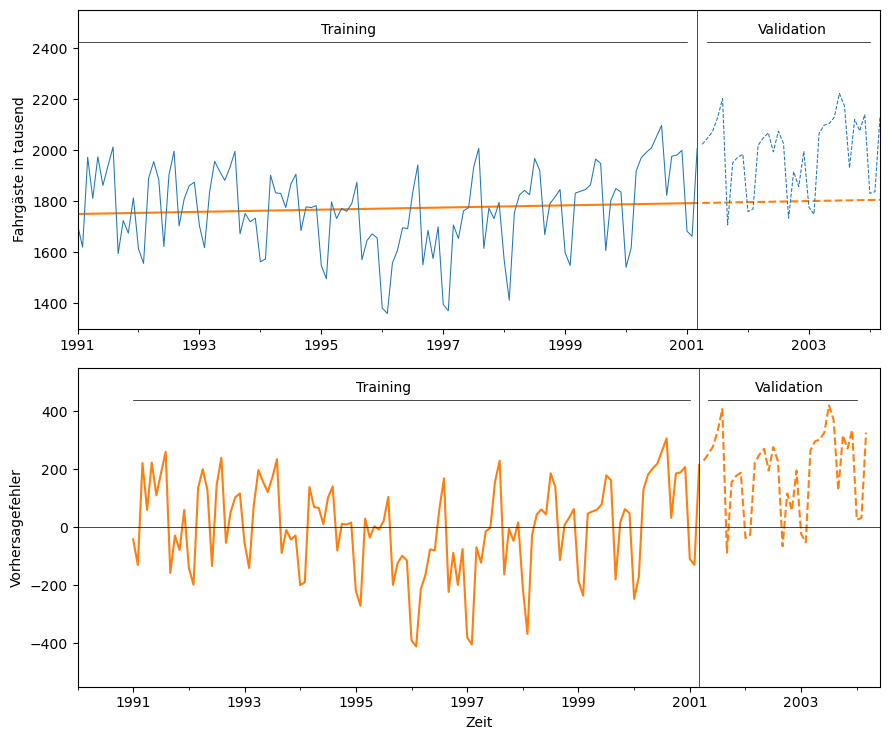

In [4]:
n_valid = 36 
n_train = len(ridership_ts) - n_valid
train_df = ridership_df[:n_train]
valid_df = ridership_df[n_train:]

ridership_prediction_linear = smf.ols(formula='Ridership ~ trend', data=train_df).fit()
predicted_linear = ridership_prediction_linear.predict(valid_df)

fig, axes = plt.subplots(nrows=2, ncols=1, figsize=(9, 7.5))
ridership_prediction_linear.predict(train_df).plot(ax=axes[0], color='C1')
ridership_prediction_linear.predict(valid_df).plot(ax=axes[0], color='C1', linestyle='dashed')

residual = train_df.Ridership - ridership_prediction_linear.predict(train_df)
residual.plot(ax=axes[1], color='C1')
residual = valid_df.Ridership - ridership_prediction_linear.predict(valid_df)
residual.plot(ax=axes[1], color='C1', linestyle='dashed')
graphLayout(axes, train_df, valid_df)
plt.tight_layout()
plt.show()

Für das Ergebnis lassen wir uns eine Auswertung ausgeben:

In [5]:
print(ridership_prediction_linear.summary())

                            OLS Regression Results                            
Dep. Variable:              Ridership   R-squared:                       0.006
Model:                            OLS   Adj. R-squared:                 -0.002
Method:                 Least Squares   F-statistic:                    0.7456
Date:                Tue, 29 Apr 2025   Prob (F-statistic):              0.390
Time:                        08:37:08   Log-Likelihood:                -797.95
No. Observations:                 123   AIC:                             1600.
Df Residuals:                     121   BIC:                             1606.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept   1750.3595     29.073     60.206      0.0

Der *Intercept* ist der Wert der Konstante $\beta_0$, *trend* der Koeffizient $\beta_1$. An ihren ggf. akzeptablen statistischen Kennzahlen sehen wir hier, dass die Betrachtung der Form des zeitlichen Verlaufs erforderlich ist, nicht nur der reinen Zahlen, denn offensichtlich gibt es hier keinen linearen Zusammenhang. 

Also versuchen wir es als nächstes mit einem *exponentiellem Trend*. Praktisch nutzen wir hier die Umformung von $Y_t = ce^{\beta_1 t + \epsilon}$ zu $\log Y_t = \beta_0 + \beta_1 t + \epsilon$. Bei der Auswertung und Darstellung müssen wir dann aber beachten, die Trainingsdaten und Vorhersagen auf die ursprüngliche Skala abzubilden. Dazu wenden wir hier die Exponentialfunktion als $\lambda$ auf die entsprechenden Werte an. 

Im Vergleich stellt sich dann ein sehr ähnliches Ergebnis wie im linearen Modell dar:

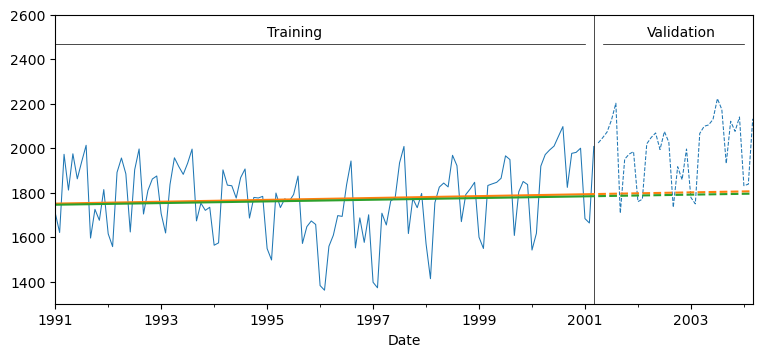

In [6]:
ridership_prediction_expo = smf.ols(formula='np.log(Ridership) ~ trend', data=train_df).fit()
predicted_expo = ridership_prediction_expo.predict(valid_df).apply(lambda row: np.exp(row))

fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(9, 3.75))
train_df.plot(y='Ridership', ax=ax, color='C0', linewidth=0.75)
valid_df.plot(y='Ridership', ax=ax, color='C0', linestyle='dashed', linewidth=0.75)
singleGraphLayout(ax, [1300, 2600], train_df, valid_df)
ridership_prediction_linear.predict(train_df).plot(color='C1')
ridership_prediction_linear.predict(valid_df).plot(color='C1', linestyle='dashed')
ridership_prediction_expo.predict(train_df).apply(lambda row: np.exp(row)).plot(color='C2')
ridership_prediction_expo.predict(valid_df).apply(lambda row: np.exp(row)).plot(color='C2', linestyle='dashed')
ax.get_legend().remove()
plt.show()

Passen wir als nächstes einen *polynomialen Trend* an. Dazu fügen wir einen weiteren Prädiktor $t^2$ in die Formel ein. Dieser quadratische Zusammenhang ist hier nahe liegend, da der Verlauf der Daten "U-förmig" wirkt.

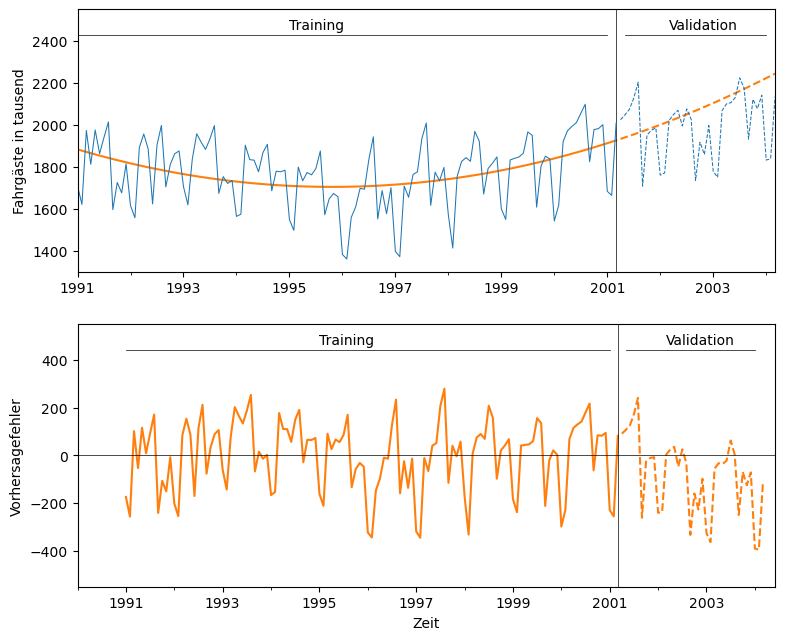

In [7]:
ridership_prediction_poly = smf.ols(formula='Ridership ~ trend + np.square(trend)', data=train_df).fit()
predicted_poly = ridership_prediction_poly.predict(valid_df)

fig, axes = plt.subplots(nrows=2, ncols=1, figsize=(9, 7.5))
ridership_prediction_poly.predict(train_df).plot(ax=axes[0], color='C1')
ridership_prediction_poly.predict(valid_df).plot(ax=axes[0], color='C1', linestyle='dashed')

residual = train_df.Ridership - ridership_prediction_poly.predict(train_df)
residual.plot(ax=axes[1], color='C1')
residual = valid_df.Ridership - ridership_prediction_poly.predict(valid_df)
residual.plot(ax=axes[1], color='C1', linestyle='dashed')
graphLayout(axes, train_df, valid_df)
plt.show()

Das Ergebnis wirkt nun passender als bei den bisherigen Ansätzen oben, da die Residuen keinen erkennbaren Trend mehr aufweisen. Diese Komponente haben wir also erfasst und wenden uns der *Saisonalität* zu.

Allgemein erfordert das eine neue kategorische Variable, die jeden Wert der Zeitreihe einer Saison zuordnet. Die Kategorien werden dann auf Dummy-Variablen abgebildet, die als Prädiktoren in das Modell eingehen. Im hier gegebenen Fall ist das der *Monat*, den wir dem Datensatz hinzufügen. Zunächst - wir wollen eine Vorhersage nur auf Basis der Saisonalität - ist der Trend dabei als konstant angenommen.

In [8]:
ridership_df = tsatools.add_trend(ridership_ts, trend='c')
ridership_df['Month'] = ridership_df.index.month
ridership_df

,Ridership,const,Month
Date,,,
1991-01-01,1708.917,1.0,1
1991-02-01,1620.586,1.0,2
1991-03-01,1972.715,1.0,3
1991-04-01,1811.665,1.0,4
1991-05-01,1974.964,1.0,5
...,...,...,...
2003-11-01,2076.054,1.0,11
2003-12-01,2140.677,1.0,12
2004-01-01,1831.508,1.0,1


Durch die Angabe `C(Month)` nimmt *statsmodels* uns die Umwandlung in Dummies ab. Auf dieser Basis machen wir dann wie gewohnt unsere Vorhersage.

In [9]:
train_df = ridership_df[:n_train]
valid_df = ridership_df[n_train:]
ridership_prediction_season = smf.ols(formula='Ridership ~ C(Month)', data=train_df).fit()
predicted_season = ridership_prediction_season.predict(valid_df)
print(ridership_prediction_season.summary())

                            OLS Regression Results                            
Dep. Variable:              Ridership   R-squared:                       0.635
Model:                            OLS   Adj. R-squared:                  0.599
Method:                 Least Squares   F-statistic:                     17.54
Date:                Tue, 29 Apr 2025   Prob (F-statistic):           1.20e-19
Time:                        08:37:08   Log-Likelihood:                -736.38
No. Observations:                 123   AIC:                             1497.
Df Residuals:                     111   BIC:                             1531.
Df Model:                          11                                         
Covariance Type:            nonrobust                                         
                     coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------
Intercept       1573.9722     30.578     51.

Das Ergebnis stellen wir grafisch dar:

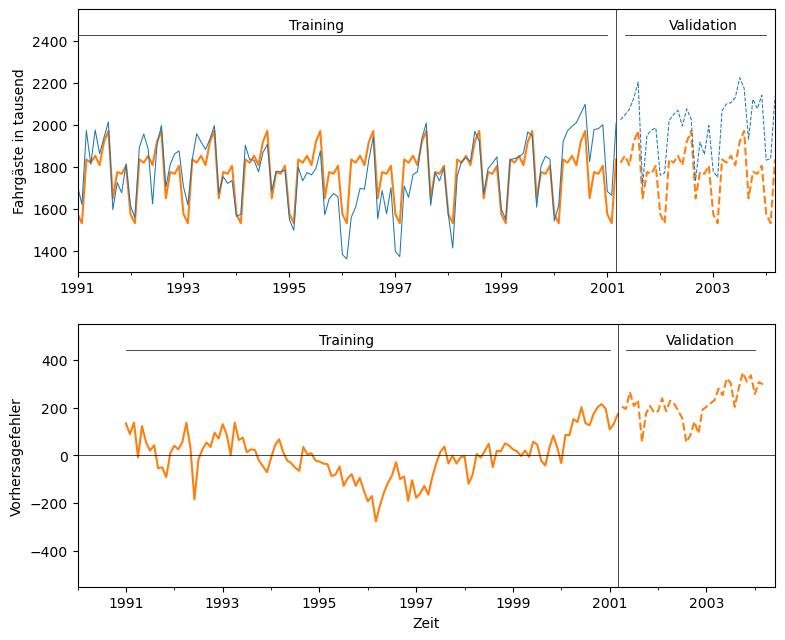

In [10]:
fig, axes = plt.subplots(nrows=2, ncols=1, figsize=(9, 7.5))
ridership_prediction_season.predict(train_df).plot(ax=axes[0], color='C1')
ridership_prediction_season.predict(valid_df).plot(ax=axes[0], color='C1', linestyle='dashed')

residual = train_df.Ridership - ridership_prediction_season.predict(train_df)
residual.plot(ax=axes[1], color='C1')
residual = valid_df.Ridership - ridership_prediction_season.predict(valid_df)
residual.plot(ax=axes[1], color='C1', linestyle='dashed')
graphLayout(axes, train_df, valid_df)
plt.show()

Das Modell erfasst die Saisonalität passend, die Residuen weisen aber wieder einen Trend auf. Also fügen wir den quadratischen Trend hinzu.

In [11]:
ridership_df = tsatools.add_trend(ridership_ts, trend='ct')
ridership_df['Month'] = ridership_df.index.month
train_df = ridership_df[:n_train]
valid_df = ridership_df[n_train:]
ridership_prediction_trend_season = smf.ols(formula='Ridership ~ trend + np.square(trend) + C(Month)', data=train_df).fit()
predicted_trend_season = ridership_prediction_trend_season.predict(valid_df)
print(ridership_prediction_trend_season.summary())

                            OLS Regression Results                            
Dep. Variable:              Ridership   R-squared:                       0.825
Model:                            OLS   Adj. R-squared:                  0.804
Method:                 Least Squares   F-statistic:                     39.42
Date:                Tue, 29 Apr 2025   Prob (F-statistic):           3.75e-35
Time:                        08:37:09   Log-Likelihood:                -691.27
No. Observations:                 123   AIC:                             1411.
Df Residuals:                     109   BIC:                             1450.
Df Model:                          13                                         
Covariance Type:            nonrobust                                         
                       coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------
Intercept         1696.9794     27.675  

Die grafische Darstellung bietet den Eindruck eines stark verbesserten Modells.

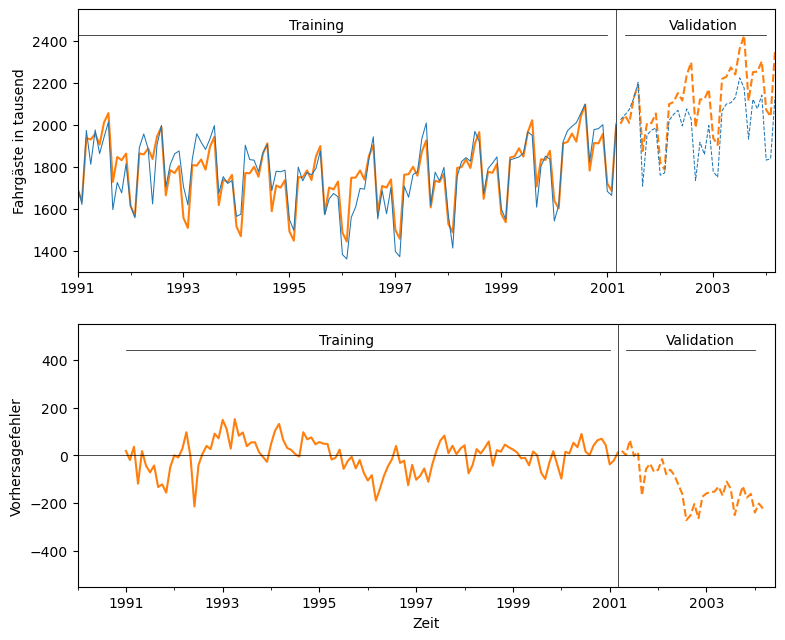

In [12]:
fig, axes = plt.subplots(nrows=2, ncols=1, figsize=(9, 7.5))
ridership_prediction_trend_season.predict(train_df).plot(ax=axes[0], color='C1')
ridership_prediction_trend_season.predict(valid_df).plot(ax=axes[0], color='C1', linestyle='dashed')

residual_train = train_df.Ridership - ridership_prediction_trend_season.predict(train_df)
residual_train.plot(ax=axes[1], color='C1')
residual_valid = valid_df.Ridership - ridership_prediction_trend_season.predict(valid_df)
residual_valid.plot(ax=axes[1], color='C1', linestyle='dashed')
graphLayout(axes, train_df, valid_df)
plt.show()

Auch eine Betrachtung der Kennzahlen der Vorhersagen gegenüber dem Validierungsdatensatz im Vergleich bestätigt diesen Eindruck:

In [13]:
print('Lineares Modell')
regressionSummary(valid_df.Ridership, predicted_linear)
print('')
print('Exponentielles Modell')
regressionSummary(valid_df.Ridership, predicted_expo)
print('')
print('Quadratisches Modell')
regressionSummary(valid_df.Ridership, predicted_poly)
print('')
print('Additiv-saisonales Modell')
regressionSummary(valid_df.Ridership, predicted_season)
print('')
print('Quadratisches Modell mit Saisonalität')
regressionSummary(valid_df.Ridership, predicted_trend_season)

Lineares Modell
                          Summe Abweichungen : 6952.7371
                 Summe absolute Abweichungen : 7539.7357
                            Mittlerer Fehler : 193.1316
                  Mittlerer absoluter Fehler : 209.4371
Wurzel des durchschnittlichen Fehlerquadrats : 239.4863
               Mittlerer prozentualer Fehler : 9.2099
     Mittlerer absoluter prozentualer Fehler : 10.1477

Exponentielles Modell
                          Summe Abweichungen : 7317.8402
                 Summe absolute Abweichungen : 7784.4691
                            Mittlerer Fehler : 203.2733
                  Mittlerer absoluter Fehler : 216.2353
Wurzel des durchschnittlichen Fehlerquadrats : 247.7550
               Mittlerer prozentualer Fehler : 9.7213
     Mittlerer absoluter prozentualer Fehler : 10.4680

Quadratisches Modell
                          Summe Abweichungen : -3022.6348
                 Summe absolute Abweichungen : 4814.5791
                            Mittlerer Fehl

## Aufgabe

Der Datensatz *a10.csv* enthält die monatlichen Absätze eines Medikamentes gegen Diabetes. Implementieren Sie ein geeignetes Modell zur Prädiktion der Absätze. Passen Sie zu diesem Zweck ggf. auch die Hilfsfunktionen zur Darstellung an.

## Autokorrelation

Zur Illustration von Autokorrelation am Beispiel der Fahrgastdaten generieren wir zunächst die verzögerten Reihen bis *lag-4* für die ersten 24 Monate.

In [14]:
lagged_riderships_df = pd.DataFrame()
for lag in range(0, 5):
    lagged_riderships_df[f'Lag {lag}'] = train_df['1991-01-01':'1992-12-01']['Ridership'].shift(lag)

lagged_riderships_df

,Lag 0,Lag 1,Lag 2,Lag 3,Lag 4
Date,,,,,
1991-01-01,1708.917,NaN,NaN,NaN,NaN
1991-02-01,1620.586,1708.917,NaN,NaN,NaN
1991-03-01,1972.715,1620.586,1708.917,NaN,NaN
1991-04-01,1811.665,1972.715,1620.586,1708.917,NaN
1991-05-01,1974.964,1811.665,1972.715,1620.586,1708.917
1991-06-01,1862.356,1974.964,1811.665,1972.715,1620.586
1991-07-01,1939.860,1862.356,1974.964,1811.665,1972.715
1991-08-01,2013.264,1939.860,1862.356,1974.964,1811.665
1991-09-01,1595.657,2013.264,1939.860,1862.356,1974.964


Die Fahrgastzahlen der ursprünglichen Zeitreihe treten in den *Lag n* jeweils *n* Monate später auf. Nun stellt sich die Frage nach der Korrelation zwischen der ursprünglichen Zeitreihe und ihren verzögerten Varianten.

In [15]:
for lag in range(0, 5):
    print('Autokorrelation Lag {} = {}'.format(lag, train_df['1991-01-01':'1992-12-01'].Ridership.autocorr(lag=lag)))

Autokorrelation Lag 0 = 0.9999999999999998
Autokorrelation Lag 1 = 0.0808770367103893
Autokorrelation Lag 2 = -0.14861057054346016
Autokorrelation Lag 3 = -0.001119613858475755
Autokorrelation Lag 4 = 0.1633305157669254


Wir sehen schwankende Werte und einen eher niedrigen Wert für *Lag 1*. Schauen wir uns also die *Autokorrelationsfunktion* ACF der Zeitreihe an, die uns *statsmodels* für den betrachteten Zeitraum liefert und auch passend darstellt.

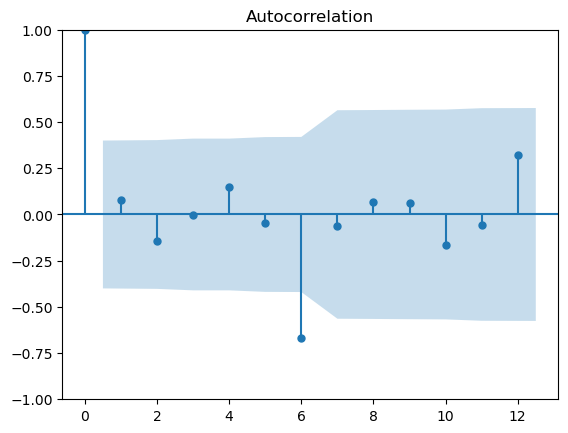

In [16]:
tsaplots.plot_acf(train_df['1991-01-01':'1992-12-01'].Ridership)
plt.show()

Hier sehen wir die stärkste Autokorrelation bei Lag 6. Sie ist negativ und liegt außerhalb des 95%-Konfidenzintervalls, was auf ein verbesserungsfähiges Modell hinweist. Außerdem erkennen wir einen halbjährliche Wechsel zwischen niedrigem und hohem Fahrgastaufkommen, was wir auch schon oben in der Zeitreihe sehen konnten.

Es kann hilfreich sein, auch die Autokorrelation der Residuen zu betrachten. Eine angemessene Modellierung der Saisonalitäten sollte die Autokorrelation der Residuen unterdrücken. Stellen wir das für unser letztes (und bestes) Modell mit Trend und Saisonalität dar:

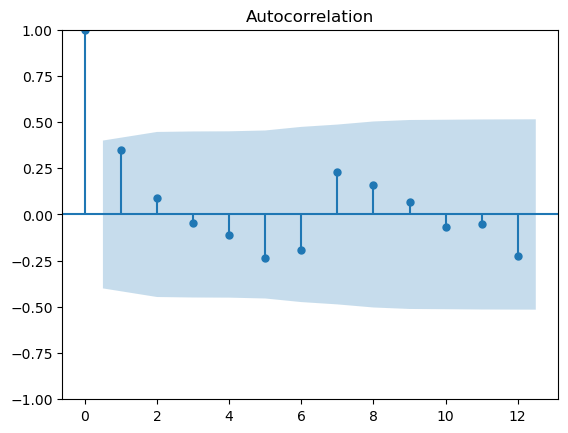

In [17]:
tsaplots.plot_acf(residual_train['1991-01-01':'1992-12-01'])
plt.show()

Hier sehen wir Autokorrelationen und eine Saisonalität, die wir nutzen können, um Vorhersagefehler vorherzusagen. Dazu passen wir die Residuen an ein vorhandenes *ARIMA*-Modell an. Es ist hier ausreichend, einen Lag von 1 anzunehmen (`order=(1,...)`), da sich hier die unmittelbaren Nachbarn beinflussen und diese Beziehung sich auch auf die folgenden Werte auswirkt.

In [18]:
train_residuals_arima = ARIMA(ridership_prediction_trend_season.resid, order=(1,0,0), freq='MS', trend='ct').fit()

/opt/anaconda3/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


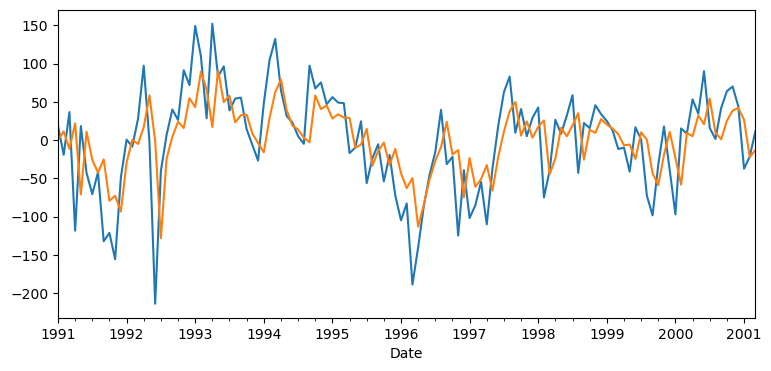

In [19]:
ax = ridership_prediction_trend_season.resid.plot(figsize=(9,4))
train_residuals_arima.fittedvalues.plot(ax=ax)
plt.show()

Die vorhergesagten Fehler sind nahe an den tatsächlichen Fehlern der Zeitreihe. Auch zeigt sich, dass nur noch eine vernachlässigbare Autokorrelation zwischen den Residuen der Fehler verbleibt:

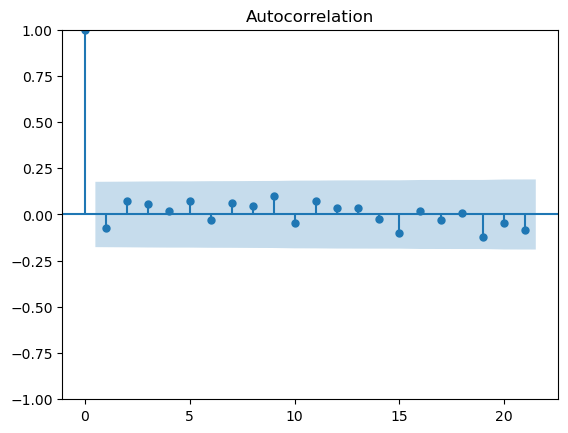

In [20]:
tsaplots.plot_acf(ridership_prediction_trend_season.resid-train_residuals_arima.fittedvalues)
plt.show()

Generieren wir eine Vorhersage des Fehlers für den April 2001 und nutzen sie zur Korrektur unserer bisherigen Vorhersage:

In [21]:
print('Tatsächlicher Wert = {}'.format(valid_df.loc['2001-04-01'].Ridership))
print('Vorhergesagter Wert = {}'.format(predicted_trend_season.loc['2001-04-01']))
print('Fehler = {}'.format(valid_df.loc['2001-04-01'].Ridership - predicted_trend_season.loc['2001-04-01']))
print('Vorhergesagter Fehler = {}'.format(train_residuals_arima.forecast(1).loc['2001-04-01']))
print('Korrigierte Vorhersage = {}'.format(predicted_trend_season.loc['2001-04-01']+train_residuals_arima.forecast(1).loc['2001-04-01']))

Tatsächlicher Wert = 2023.792
Vorhergesagter Wert = 2004.2708927643994
Fehler = 19.52110723560054
Vorhergesagter Fehler = 7.4310401132284625
Korrigierte Vorhersage = 2011.7019328776278


Durch die spezifischen Eigenschaften der AR-Modelle eignen sie sich eher zur kurzfristigen Vorhersage der nächsten *k* Perioden. Danach greifen sie auf frühere Vorhersagen zurück.